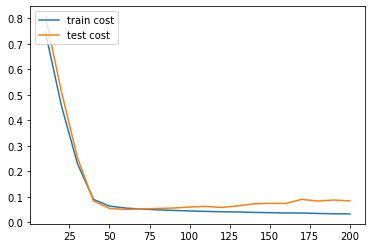

test cost, Step 200, Cost 0.084372


<Figure size 432x288 with 0 Axes>

In [1]:
from __future__ import print_function
import paddle
import paddle.fluid as fluid
import numpy as np
import math
import csv
from paddle.utils.plot import Ploter
import sys

ITERABLE = True
TRAIN_DATA = []
TEST_DATA = []
TRAIN_RES = []
TEST_RES = []
TRAIN_FILE = "./iris_training.csv"
TEST_FILE = "./iris_test.csv"


def data_pretreatment():
    # train
    with open(TRAIN_FILE) as f:
        render = csv.reader(f)
        for row in render:
            if len(row) != 0:
                TRAIN_DATA.append([row[0], row[1], row[2], row[3]])
                TRAIN_RES.append([row[4]])

    # test
    with open(TEST_FILE) as f:
        render = csv.reader(f)
        for row in render:
            if len(row) != 0:
                TEST_DATA.append([row[0], row[1], row[2], row[3]])
                TEST_RES.append([row[4]])


def train_sample_reader():
    for i in range(120):
        input = np.array(TRAIN_DATA).astype('float32')
        label = np.array(TRAIN_RES).astype('int64')
        yield input, label

def test_sample_reader():
    for i in range(30):
        input = np.array(TEST_DATA).astype('float32')
        label = np.array(TEST_RES).astype('int64')
        yield input, label


def train(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    for data_test in reader():
        outs = executor.run(program=program,
                            feed=feeder.feed(data_test),
                            fetch_list=fetch_list)
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)]  # 累加测试过程中的损失值
        count += 1  # 累加测试集中的样本数量
    return [x_d / count for x_d in accumulated]

# 训练部分

# data pretreatment
data_pretreatment()
train_reader = fluid.io.batch(train_sample_reader, batch_size=100)
test_reader = fluid.io.batch(test_sample_reader, batch_size=100)

# network
INPUT = fluid.data(name='input', shape=[None, 4], dtype='float32')
LABEL = fluid.data(name='label', shape=[None, 1], dtype='int64')
hidden = fluid.layers.fc(name='fc1', input=INPUT, size=10, act='relu')
hidden = fluid.layers.fc(name='fc2', input=hidden, size=20, act='relu')
hidden = fluid.layers.fc(name='fc3', input=hidden, size=10, act='relu')
prediction = fluid.layers.fc(name='soft', input=hidden, size=3, act='softmax')

# main program
main_program = fluid.default_main_program()  # 获取默认/全局主函数
startup_program = fluid.default_startup_program()

# loss
loss = fluid.layers.mean(fluid.layers.cross_entropy(input=prediction, label=LABEL))
acc = fluid.layers.accuracy(input=prediction, label=LABEL)

# test program
test_program = main_program.clone(for_test=True)
adam = fluid.optimizer.Adam(learning_rate=0.01)
adam.minimize(loss)

place = fluid.CUDAPlace(0)
exe = fluid.Executor(place)

num_epochs = 100


params_dirname = "./my_paddle_model"
feeder = fluid.DataFeeder(place=place, feed_list=[INPUT, LABEL])
exe.run(startup_program)
train_prompt = "train cost"
test_prompt = "test cost"

%matplotlib inline
plot_prompt = Ploter(train_prompt, test_prompt)
step = 0

exe_test = fluid.Executor(place)

for pass_id in range(num_epochs):
    for data_train in train_reader():
        step = step + 1
        avg_loss_value, = exe.run(main_program, feed=feeder.feed(data_train), fetch_list=[loss])
        if step % 10 == 0:  # 每10个批次记录并输出一下训练损失
            plot_prompt.append(train_prompt, step, avg_loss_value[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" % (train_prompt, step, avg_loss_value[0]))
        if step % 10 == 0:  # 每100批次记录并输出一下测试损失
            test_metics = train(executor=exe_test, program=test_program, reader=test_reader, fetch_list=[loss.name], feeder=feeder)
            plot_prompt.append(test_prompt, step, test_metics[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" % (test_prompt, step, test_metics[0]))
            if test_metics[0] < 10.0:  # 如果准确率达到要求，则停止训练
                break

        if math.isnan(float(avg_loss_value[0])):
            sys.exit("got NaN loss, training failed.")

        #  保存训练参数到之前给定的路径中
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname, ['input'], [prediction], exe)

In [2]:
# 预测部分

def save_result(points1, points2):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    x1 = [idx for idx in range(len(points1))]
    y1 = points1
    y2 = points2
    l1 = plt.plot(x1, y1, 'r--', label='predictions')
    l2 = plt.plot(x1, y2, 'g--', label='GT')
    plt.plot(x1, y1, 'ro-', x1, y2, 'g+-')
    plt.title('predictions VS GT')
    plt.legend()
    plt.savefig('./my_paddle_model/prediction_gt.png')

infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

pred_array = []

with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe) # 载入预训练模型=
    batch_size = 10
    iris_reader = fluid.io.batch(
        test_reader, batch_size=10
    )
    iris_feat = np.array(TEST_DATA).astype("float32")
    iris_label = np.array(TEST_RES).astype("int64")

    assert feed_target_names[0] == 'input'
    results = infer_exe.run(inference_program,
                            feed={feed_target_names[0]: np.array(iris_feat)},
                            fetch_list=fetch_targets)

    print("Iris results: (Iris Type)")
    for idx, val in enumerate(results[0]):
        pred = val.tolist().index(np.max(val))
        pred_array.append([pred])
        print("%d: %f" % (idx, pred))  # 打印预测结果

    save_result(pred_array, iris_label)

C:\ProgramData\Miniconda3\envs\pdpd\lib\site-packages\paddle\fluid\executor.py:1070: UserWarning: The following exception is not an EOF exception.
  "The following exception is not an EOF exception.")


EnforceNotMet: 

--------------------------------------------
C++ Call Stacks (More useful to developers):
--------------------------------------------
Windows not support stack backtrace yet.

----------------------
Error Message Summary:
----------------------
Error: Incompatible data or style type: tensor.set() supports bool, float16, float32, float64, int8, int16, int32, int64 and uint8, uint16, but got <U3! at (D:\1.8.3\paddle\paddle/fluid/pybind/tensor_py.h:242)
